# Imports

In [1]:
import pandas as pd
import numpy as np
from ForexEnv_RQ5 import ForexEnv
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt

# Loading data

In [2]:
# --- Notebook Cell 2: Load Bid and Ask Data ---
bid_path = '../data/forex/EURUSD/15M/BID/10.05.2022T00.00-10.05.2025T23.45.csv'
ask_path = '../data/forex/EURUSD/15M/ASK/10.05.2022T00.00-10.05.2025T23.45.csv'

bid_df = pd.read_csv(bid_path, parse_dates=['date_gmt'])
ask_df = pd.read_csv(ask_path, parse_dates=['date_gmt'])

bid_df.set_index('date_gmt', inplace=True)
ask_df.set_index('date_gmt', inplace=True)

# Merge BID and ASK data

In [3]:
df_raw = bid_df.add_suffix('_bid').join(ask_df.add_suffix('_ask'), how='inner')

# Rename volume column if needed (assume from bid)
df_raw.rename(columns={'volume_bid': 'volume'}, inplace=True)
df_raw.drop(columns=['volume_ask'], errors='ignore', inplace=True)

# Ensure volume is float
df_raw['volume'] = df_raw['volume'].astype(float)

# Train / test split

In [4]:
train_split = 0.7
split_idx = int(len(df_raw) * train_split)
train_df = df_raw.iloc[:split_idx]
test_df = df_raw.iloc[split_idx:]

print("Train samples:", len(train_df))
print("Test samples:", len(test_df))

Train samples: 36029
Test samples: 15442


# Environment setup

In [5]:
train_env = DummyVecEnv([lambda: ForexEnv(train_df, log_level=0)])
test_env = DummyVecEnv([lambda: ForexEnv(test_df, log_level=0)])

# DQN Model

In [6]:
policy_kwargs = dict(net_arch=[128, 128])

model = DQN(
    policy="MlpPolicy",
    env=train_env,
    learning_rate=0.001,
    buffer_size=50000,
    learning_starts=1000,
    batch_size=64,
    tau=1.0,
    gamma=0.99,
    train_freq=4,
    gradient_steps=1,
    target_update_interval=500,
    exploration_fraction=0.2,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.05,
    policy_kwargs=policy_kwargs,
    verbose=1,
    seed=42,
)

Using cpu device


# Train

In [7]:
TOTAL_TIMESTEPS = 50000
model.learn(total_timesteps=TOTAL_TIMESTEPS, log_interval=100)
model.save("dqn_forex_model")

# Test

In [9]:
obs = test_env.reset()
done = [False]
total_rewards_eval = 0
step = 0
actions = []
equity_curve = []

while not done[0]:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = test_env.step(action)
    total_rewards_eval += reward[0]
    step += 1
    actions.append(action[0])
    equity_curve.append(info[0].get("equity", np.nan))

print(f"Total evaluation steps: {step}")
print(f"Total reward: {total_rewards_eval:.2f}")


Total evaluation steps: 15410
Total reward: -416.95


# Visualization

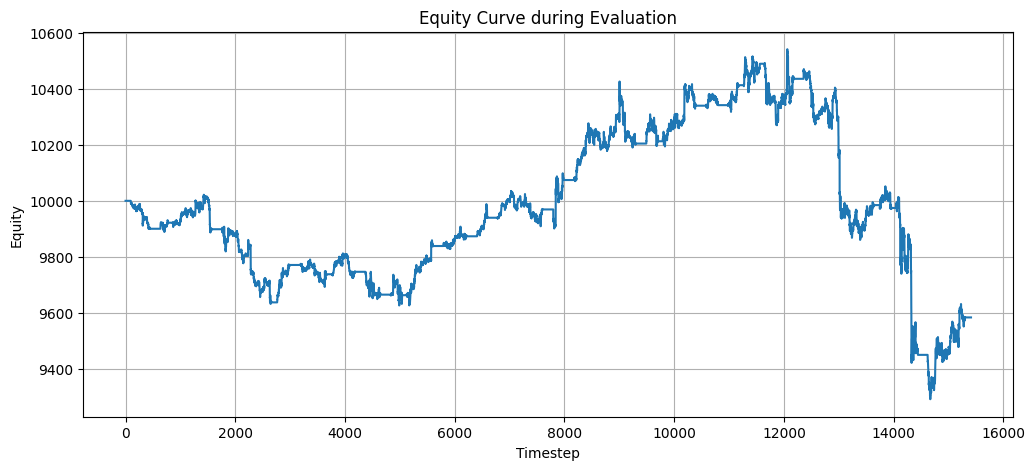

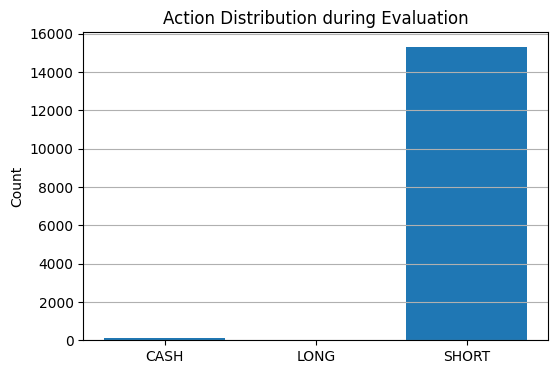

In [11]:
# --- Notebook Cell 9: Visualize Results ---
from typing import Counter


plt.figure(figsize=(12, 5))
plt.plot(equity_curve)
plt.title("Equity Curve during Evaluation")
plt.xlabel("Timestep")
plt.ylabel("Equity")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
action_counts = Counter(actions)
labels = ['CASH', 'LONG', 'SHORT']
values = [action_counts.get(i, 0) for i in range(3)]
plt.bar(labels, values)
plt.title("Action Distribution during Evaluation")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()